In [4]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Font size settings for figures
mpl.rcParams.update({
    "font.size": 14,              # base font size
    "axes.titlesize": 16,         # title font
    "axes.labelsize": 14,         # x/y label font
    "xtick.labelsize": 12,        # x-tick labels
    "ytick.labelsize": 12,        # y-tick labels
    "legend.fontsize": 12,        # legend text
    "lines.linewidth": 2,         # line thickness
    "axes.linewidth": 1.2,        # axis border thickness
})

# Function to make annotating data on figures easier
def annotate_final_values(ax, x, y_values, labels, min_sep_frac=0.1):
    """
    Adds annotations at the final time point of each y-series with spacing done in axis-fraction units.

    Parameters:
        ax: matplotlib Axes object
        x: time points (1D array)
        y_values: list of y-arrays
        labels: list of label strings
        min_sep_frac: minimum spacing between annotations in axis fraction (0.03 = 3% of y-axis height)
    """
    final_x = x[-1]
    final_ys = [y[-1] for y in y_values]
    y_min, y_max = ax.get_ylim()

    # Convert y-values to axis-fraction space
    y_fracs = [(y - y_min) / (y_max - y_min) for y in final_ys]

    # Sort and apply minimum spacing in axis-fraction space
    sorted_indices = np.argsort(y_fracs)
    new_frac_positions = {}
    last_frac = None
    for idx in sorted_indices:
        frac = y_fracs[idx]
        if last_frac is None:
            new_frac_positions[idx] = frac
        else:
            new_frac_positions[idx] = max(frac, last_frac + min_sep_frac)
        last_frac = new_frac_positions[idx]

    # Clamp to [0,1] and convert back to data coordinates
    for idx in range(len(y_values)):
        orig_y = final_ys[idx]
        frac_y = min(new_frac_positions[idx], 0.98)  # avoid going out of bounds
        adjusted_y = y_min + frac_y * (y_max - y_min)

        ax.annotate(f"{labels[idx]}\n{orig_y:.0f}",
                    xy=(final_x, orig_y),
                    xytext=(final_x + 1, adjusted_y),
                    textcoords='data',
                    fontsize=8,
                    va='center',
                    ha='left',
                    arrowprops=dict(arrowstyle='->', lw=0.5),
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", lw=0.5))

Models are in order of priority for review (please start at the top, earlier models are more important for review than later models)

---

# Volume-Scaled Neuroblast Growth and Division Threshold Model:

## Model Purpose
This model assesses whether the reduced cell counts observed in mudmut neuroblast (NB) colonies could be explained by a size-dependent growth rate. The underlying hypothesis is:
- Growth rate effect: Symmetric NB divisions in mudmut colonies produce daughter NBs with much smaller starting volumes than WT NBs. If cell growth rate scales with cell size, these smaller starting volumes would cause slower growth rates, leading to fewer NB divisions over time and, ultimately, fewer total cells.
- Division threshold effect: Experimental evidence also suggests that mudmut NBs divide at proportionally smaller threshold volumes than WT NBs. This could counterbalance the slower growth rate effect by allowing smaller cells to divide sooner.

The model incorporates volume-dependent a growth rate and a volume-scaled division threshold to evaluate whether these competing effects can account for the observed difference in cell counts between WT and mudmut colonies.

## Review Requests
Please check:
- that the structure of my equations matches my descriptions of my intended dynamics
- that the structure adequately models the intended dynamics (perhaps my words and equations match but are inadequate for testing the hypothesis described above). **This is my greatest concern here**.

## Model Species
- **$N_{\text{NB}}, V_{\text{NB}}$** — Neuroblast count & total NB volume
- **$N_{\text{GMC}}, V_{\text{GMC}}$** — GMC count & total GMC volume
- **$N_{\text{ImNeuron}}, V_{\text{ImNeuron}}$** — Immature neuron count & volume
- **$N_{\text{MatNeuron}}, V_{\text{MatNeuron}}$** — Mature neuron count & volume

## Model Parameters
- $g_{\text{NB,base}}$ — Base NB growth rate
- $g_{\text{GMC}}$ — GMC growth rate
- $k_{\text{Neuron}}$ — Neuron maturation rate
- $\text{sym\_frac}$ — Fraction of symmetric NB divisions
- $V_{\text{ref}}$ — Reference NB volume for scaling (equal to WT NB division threshold)
- $V_{\text{thresh,base}}$ — Base NB division threshold (currently setting equal to $V_{\text{ref}}$)
- $V_{\text{thresh,GMC}}$ — GMC division threshold
- $V_{\text{floor,NB}}$ — Minimum NB volume required for division
- $k_{\text{max,NB}}$ — Maximum NB division rate
- $k_{\text{max,GMC}}$ — Maximum GMC division rate
- $n$ — Hill coefficient controlling steepness of the division rate response to volume
- $\alpha_{\text{growth}}$ — Scaling exponent for NB growth rate reduction at small volumes
- $\alpha_{\text{thresh}}$ — Scaling exponent for NB division threshold reduction at small volumes

## Model Terms

### Average Cell Volumes
The average volume for each species is the total volume of the species divided by the number of cells of that species:
$$
\bar{V}_{\text{NB}} = \frac{V_{\text{NB}}}{N_{\text{NB}}}, \quad
\bar{V}_{\text{GMC}} = \frac{V_{\text{GMC}}}{N_{\text{GMC}}}, \quad
\bar{V}_{\text{ImNeuron}} = \frac{V_{\text{ImNeuron}}}{N_{\text{ImNeuron}}}
$$

### Scaling Mechanisms for Neuroblast Growth Rate and Division Threshold
This model uses two power‐law scaling rules to adjust the neuroblast (NB) growth rate and NB division threshold based on the current average NB volume $\bar{V}{\text{NB}}$. Both are expressed relative to a reference volume $V{\text{ref}}$, set equal to the WT NB division threshold. This threshold is roughly the largest NB volume expected during simulations, making the provided base growth rate $g_{\text{NB,base}}$ and base threshold $V_{\text{ref}}$ roughly represent maximum possible values in the model. Any decrease in $\bar{V}{\text{NB}}$ below $V{\text{ref}}$ proportionally reduces growth rate and threshold according to the scaling exponents.

**Growth Rate Scaling**

When $\bar{V}{\text{NB}}$ is smaller than $V{\text{ref}}$, the NB growth rate is reduced. The exponent $\alpha_{\text{growth}}$ controls the sensitivity of this slowdown: higher values mean stronger reduction for small cells.

$$
g_{\text{NB,eff}} = g_{\text{NB,base}} \cdot \left( \frac{\bar{V}{\text{NB}}}{V{\text{ref}}} \right)^{\alpha_{\text{growth}}}
$$
- $g_{\text{NB,base}}$ – Maximum NB growth rate (when $\bar{V}{\text{NB}} = V{\text{ref}}$).
- $\alpha_{\text{growth}}$ – Scaling strength: larger values produce greater slowdown at smaller sizes.

**Division Threshold Scaling**

The NB division threshold volume is reduced in proportion to $\bar{V}{\text{NB}}$ when cells are smaller than $V{\text{ref}}$. The exponent $\alpha_{\text{thresh}}$ controls how strongly the threshold is reduced.

$$
V_{\text{thresh,eff}} = V_{\text{ref}} \cdot \left( \frac{\bar{V}{\text{NB}}}{V{\text{ref}}} \right)^{\alpha_{\text{thresh}}}
$$
- $V_{\text{ref}}$ – WT NB division threshold volume (maximum threshold in the model).
- $\alpha_{\text{thresh}}$ – Scaling strength: larger values reduce the threshold more sharply for smaller cells.

### NB Division Rate
The neuroblast division rate depends on how close the average neuroblast volume $\bar{V}{\text{NB}}$ is to the effective division threshold $V{\text{thresh,eff}}$. This relationship is modeled with a Hill function, which ensures a smooth, sigmoidal transition from slow to fast division rates as cell volume approaches and exceeds the threshold. Neuroblasts must also exceed a minimum volume $V_{\text{floor,NB}}$ before they can divide.

$$
k_{\text{NB}} =
\begin{cases}
k_{\text{max,NB}} \cdot \frac{\bar{V}_{\text{NB}}^n}{V_{\text{thresh,eff}}^n + \bar{V}_{\text{NB}}^n}, & \text{if } \bar{V}_{\text{NB}} \ge V_{\text{floor,NB}} \\
0, & \text{otherwise}
\end{cases}
$$
- $k_{\text{max,NB}}$ – Maximum possible NB division rate.
- $n$ – Hill coefficient controlling the steepness of the transition between low and high division rates.
- $V_{\text{thresh,eff}}$ – Effective division threshold volume (scaled as described in Scaling Mechanisms).
- $V_{\text{floor,NB}}$ – Minimum cell volume required for division to be possible.

### GMC Division Rate

Similar to NB division rate, the GMC division rate depends on how close the average GMC volume $\bar{V}{\text{GMC}}$ is to the GMC division threshold $V{\text{thresh,GMC}}$. This relationship is also modeled using a Hill function.

If there are no GMCs present ($N_{\text{GMC}} = 0$), the division rate is set to zero.

$$
k_{\text{GMC}} =
\begin{cases}
k_{\text{max,GMC}} \cdot \frac{\bar{V}_{\text{GMC}}^n}{V_{\text{thresh,GMC}}^n + \bar{V}_{\text{GMC}}^n}, & \text{if } N_{\text{GMC}} > 0 \\
0, & \text{otherwise}
\end{cases}
$$
- $k_{\text{max,GMC}}$ – Maximum possible GMC division rate.
- $V_{\text{thresh,GMC}}$ – GMC division threshold volume; when $\bar{V}_{\text{GMC}}$ equals this value, the division rate is at half‐maximum.
- $n$ – Hill coefficient controlling the steepness of the transition from low to high division rates.

### Partitioning of Neuroblast Divisions
This model partitions all neuroblast (NB) divisions into two categories: symmetric and asymmetric. The parameter $\text{sym\_frac}$ specifies the fraction of NB divisions that are symmetric.
- Symmetric divisions produce two daughter NBs.
- Asymmetric divisions produce one NB and one GMC.

The number of each type of division per time step is proportional to the NB division rate $k_{\text{NB}}$ and the current number of neuroblasts $N_{\text{NB}}$:

$$
\text{sym\_divs} = \text{sym\_frac} \cdot k_{\text{NB}} \cdot N_{\text{NB}}, \quad
\text{asym\_divs} = (1 - \text{sym\_frac}) \cdot k_{\text{NB}} \cdot N_{\text{NB}}
$$
- $\text{sym\_frac}$ – Fraction of divisions that are symmetric.
- $k_{\text{NB}}$ – Effective NB division rate (from Hill equation or other regulation).
- $N_{\text{NB}}$ – Current number of neuroblasts in the population.

### ODE System
**Neuroblast Count Change**
Neuroblasts population only increases through symmetric divisions.
$$
\frac{dN_{\text{NB}}}{dt} = \text{sym\_divs}
$$
**Neuroblast Volume Change**
Total NB volume increases through cell growth and decreases through asymmetric divisions.
With each asymmetric division, 20% of the average NB volume is transferred to GMCs.
$$
\frac{dV_{\text{NB}}}{dt}
= g_{\text{NB,eff}} \cdot N_{\text{NB}}
- 0.2 \cdot \text{asym\_divs} \cdot \bar{V}_{\text{NB}}
$$

**GMC Count Change**
Total GMC count increases when new GMCs are produced through asymmetric NB divisions and decreases as GMCs divide into immature neurons.

$$
\frac{dN_{\text{GMC}}}{dt}
= \text{asym\_divs}
- k_{\text{GMC}} \cdot N_{\text{GMC}}
$$

**GMC Volume Change**
Total GMC volume increases through cell growth and the inheritance of 20% of the average NB volume from each asymmetric NB division.
It decreases when GMCs divide into immature neurons, with each division removing an average GMC volume from the pool.

$$
\frac{dV_{\text{GMC}}}{dt}
= g_{\text{GMC}} \cdot N_{\text{GMC}}
+ \text{asym\_divs} \cdot 0.2 \cdot \bar{V}_{\text{NB}}
- k_{\text{GMC}} \cdot N_{\text{GMC}} \cdot \bar{V}_{\text{GMC}}
$$

**Immature Neuron Count Change**
Total immature neuron count increases when new immature neurons are produced through GMC divisions. Total immature neurons count decreases when immature neurons differentiate into mature neurons.
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2 \cdot k_{\text{GMC}} \cdot N_{\text{GMC}} - k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$

**Immature Neuron Volume Change**
Total immature neuron volume increases when GMCs divide, transferring their full average GMC volume to immature neurons.
It decreases when immature neurons mature into mature neurons, removing the full average immature neuron volume from the pool.
$$
\frac{dV_{\text{ImNeuron}}}{dt}
= k_{\text{GMC}} \cdot N_{\text{GMC}} \cdot \bar{V}_{\text{GMC}}
- k_{\text{Neuron}} \cdot N_{\text{ImNeuron}} \cdot \bar{V}_{\text{ImNeuron}}
$$

**Mature Neuron Count Change**
Total mature neuron count increases when immature neurons fully mature, with each immature neuron producing one mature neuron.
$$
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$

**Mature Neuron Volume Change**
Total mature neuron volume increases when immature neurons mature, transferring their full average immature neuron volume into the mature neuron population.
$$
\frac{dV_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}} \cdot N_{\text{ImNeuron}} \cdot \bar{V}_{\text{ImNeuron}}
$$

## Python Code (Neda skip I'm putting this here for my own organizational purposes)

In [3]:
def neuroblast_model_vol_scaled_growth_and_threshold(t, y, params):
    """
    NB growth and division threshold scale with current NB size.
    """
    (N_NB, V_NB,
     N_GMC, V_GMC,
     N_ImNeuron, V_ImNeuron,
     N_MatNeuron, V_MatNeuron) = y

    (g_NB_base, g_GMC,
     k_Neuron,
     sym_frac,
     V_thresh_base,
     V_thresh_GMC,
     k_max_NB, k_max_GMC,
     n,
     V_floor_NB,
     V_ref,
     alpha_growth, alpha_thresh) = params

    # Averages
    Vavg_NB       = V_NB / N_NB if N_NB > 0 else 0.0
    Vavg_GMC      = V_GMC / N_GMC if N_GMC > 0 else 0.0
    Vavg_ImNeuron = V_ImNeuron / N_ImNeuron if N_ImNeuron > 0 else 0.0

    # Instantaneous scaling
    ratio         = (Vavg_NB / V_ref) if V_ref > 0 else 1.0
    g_NB_eff      = g_NB_base    * (ratio ** alpha_growth)
    V_thresh_eff  = V_thresh_base * (ratio ** alpha_thresh)

    # NB division rate (with floor)
    if N_NB > 0 and Vavg_NB >= V_floor_NB and V_thresh_eff > 0:
        k_NB = k_max_NB * (Vavg_NB**n) / (V_thresh_eff**n + Vavg_NB**n)
    else:
        k_NB = 0.0

    # GMC division rate (fixed threshold)
    if N_GMC > 0 and V_thresh_GMC > 0:
        k_GMC = k_max_GMC * (Vavg_GMC**n) / (V_thresh_GMC**n + Vavg_GMC**n)
    else:
        k_GMC = 0.0

    # Divisions
    sym_divs  = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # Dynamics
    dN_NB = sym_divs
    dV_NB = g_NB_eff * N_NB - 0.2 * asym_divs * Vavg_NB

    dN_GMC = asym_divs - k_GMC * N_GMC
    dV_GMC = (
        g_GMC * N_GMC
        + asym_divs * 0.2 * Vavg_NB
        - k_GMC * N_GMC * Vavg_GMC
    )

    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dV_ImNeuron = (
        k_GMC * N_GMC * Vavg_GMC
        - k_Neuron * N_ImNeuron * Vavg_ImNeuron
    )

    dN_MatNeuron = k_Neuron * N_ImNeuron
    dV_MatNeuron = k_Neuron * N_ImNeuron * Vavg_ImNeuron

    return [
        dN_NB, dV_NB,
        dN_GMC, dV_GMC,
        dN_ImNeuron, dV_ImNeuron,
        dN_MatNeuron, dV_MatNeuron
    ]

WT Simulation

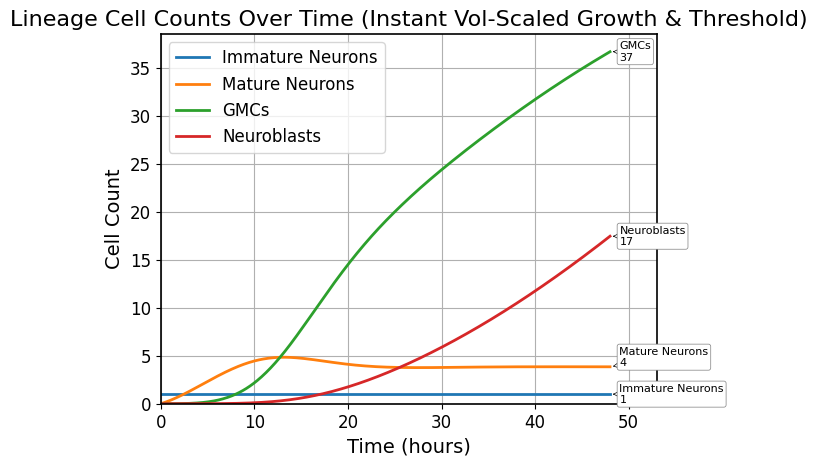

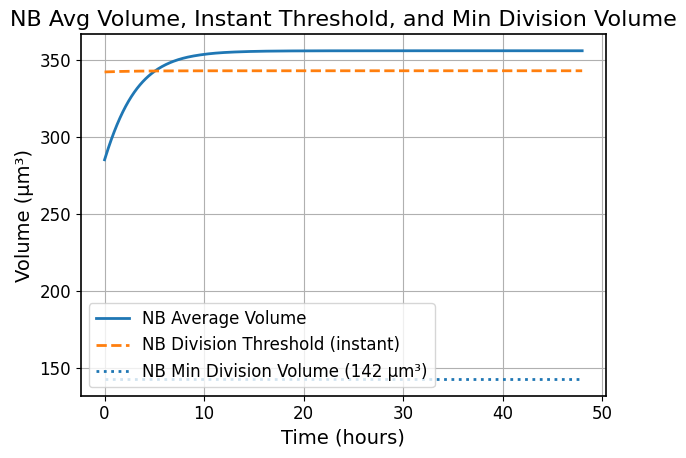

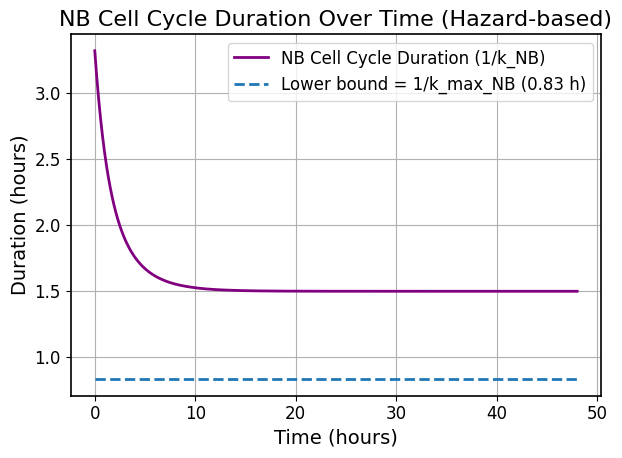

In [5]:
# --- WT params (volume-scaled growth and division threshold) ---
nb_vol = 285                                # Initial neuroblast volume (µm³)

V_thresh_base = 1.2 * nb_vol                # Base NB threshold at V_ref
g_NB_base = g_NB_base = nb_vol * 0.2 / 1.5  # NB base growth rate (volume/hr)
g_GMC     = (nb_vol * 1.2 * 0.2) / 9        # GMC growth rate (volume/hr)

V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2     # Fixed GMC division threshold volume (µm³)
k_max_NB  = 1.2                             # Max NB division rate (divisions/hr)
k_max_GMC = 1 / 1.5                         # Max GMC division rate (divisions/hr)
n         = 6                               # Hill coefficient

sym_frac  = 0                               # Fraction of NB divisions that are symmetric
k_Neuron  = 1 / 48                          # Immature neuron maturation rate (transitions/hr)
V_floor_NB    = nb_vol / 2.0                # Minimum avg NB volume before division is allowed

# Instantaneous scaling parameters
V_ref         = nb_vol                      # Reference volume
alpha_growth  = 1                           # Growth sensitivity to NB volume
alpha_thresh  = 0.01                        # Threshold sensitivity to NB volume (much smaller)

# Parameter order:
# (g_NB_base, g_GMC, k_Neuron, sym_frac,
#  V_thresh_base, V_thresh_GMC,
#  k_max_NB, k_max_GMC, n,
#  V_floor_NB, V_ref, alpha_growth, alpha_thresh)
params_vol_scaled_instant = [
    g_NB_base, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_base, V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    V_floor_NB, V_ref,
    alpha_growth, alpha_thresh
]

# Initial conditions
# [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# --- Solve ---
sol_vol_scaled = solve_ivp(
    neuroblast_model_vol_scaled_growth_and_threshold,
    t_span, y0, t_eval=t_eval, args=(params_vol_scaled_instant,)
)

# ========== Plot 1: Cell counts ==========
fig, ax = plt.subplots()
labels  = ["Immature Neurons", "Mature Neurons", "GMCs", "Neuroblasts"]
indices = [0, 2, 4, 6]
y_data  = [sol_vol_scaled.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_vol_scaled.t, y, label=label)

ax.set_xlim(0, sol_vol_scaled.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_vol_scaled.t, y_data, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("Lineage Cell Counts Over Time (Instant Vol-Scaled Growth & Threshold)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 2: NB avg volume vs  threshold (+ floor) ==========
Vavg_NB = np.divide(sol_vol_scaled.y[1], sol_vol_scaled.y[0],
                    out=np.zeros_like(sol_vol_scaled.y[1]),
                    where=sol_vol_scaled.y[0] > 0)

# Instantaneous threshold over time:
Vthresh_NB_t = V_thresh_base * (np.divide(Vavg_NB, V_ref,
                                          out=np.ones_like(Vavg_NB),
                                          where=V_ref > 0) ** alpha_thresh)

fig, ax = plt.subplots()
ax.plot(sol_vol_scaled.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_vol_scaled.t, Vthresh_NB_t, '--', label="NB Division Threshold (instant)")
ax.hlines(V_floor_NB, sol_vol_scaled.t[0], sol_vol_scaled.t[-1],
          linestyles=":", label=f"NB Min Division Volume ({V_floor_NB:.0f} µm³)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Avg Volume, Instant Threshold, and Min Division Volume")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# ========== Plot 3: Cell cycle duration ==========
# Recompute Vavg and ratio (already in cell, but keep local for clarity)
Vavg_NB = np.divide(sol_vol_scaled.y[1], sol_vol_scaled.y[0],
                    out=np.zeros_like(sol_vol_scaled.y[1]),
                    where=sol_vol_scaled.y[0] > 0)
ratio = np.divide(Vavg_NB, V_ref, out=np.ones_like(Vavg_NB), where=V_ref > 0)

# Instant effective threshold series for NBs
V_thresh_eff_series = V_thresh_base * (ratio ** alpha_thresh)

# Instantaneous NB division rate from the same Hill form used in the ODE
with np.errstate(divide='ignore', invalid='ignore'):
    k_NB_series = np.where(
        Vavg_NB >= V_floor_NB,
        k_max_NB * (Vavg_NB**n) / (V_thresh_eff_series**n + Vavg_NB**n),
        0.0
    )

# Cell-cycle duration from division hazard (bounded by 1/k_max_NB)
ccd_hazard = np.where(k_NB_series > 0, 1.0 / k_NB_series, np.nan)

fig, ax = plt.subplots()
ax.plot(sol_vol_scaled.t, ccd_hazard, color="purple", label="NB Cell Cycle Duration (1/k_NB)")
ax.hlines(1.0 / k_max_NB, sol_vol_scaled.t[0], sol_vol_scaled.t[-1],
          linestyles="--", label=f"Lower bound = 1/k_max_NB ({1.0/k_max_NB:.2f} h)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Duration (hours)")
ax.set_title("NB Cell Cycle Duration Over Time (Hazard-based)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

mudmut Simulation

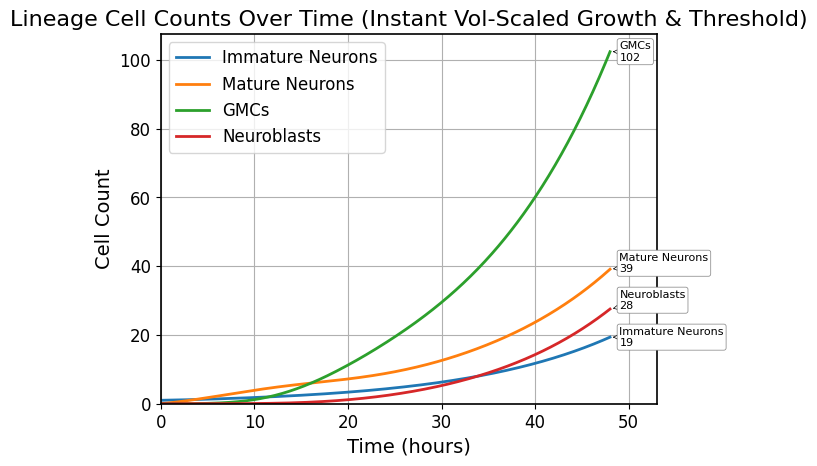

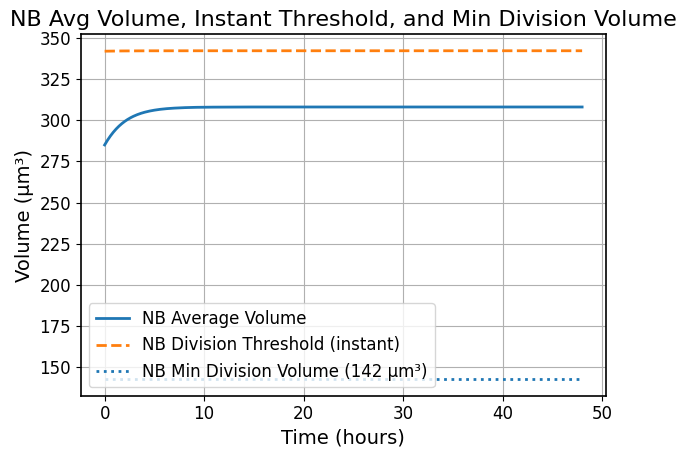

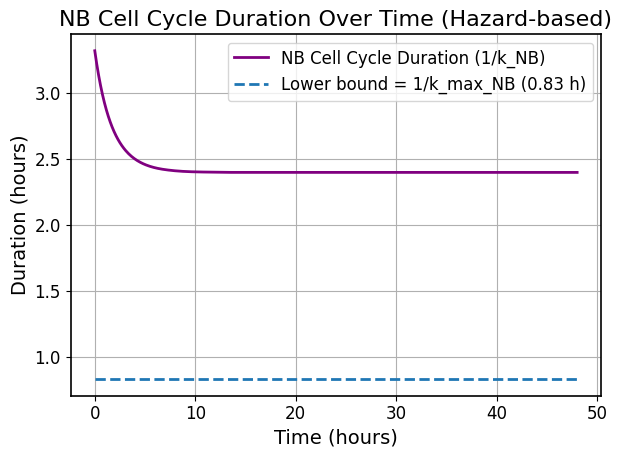

In [6]:
# --- WT params (volume-scaled growth and division threshold) ---
nb_vol = 285                                # Initial neuroblast volume (µm³)

V_thresh_base = 1.2 * nb_vol                # Base NB threshold at V_ref
g_NB_base = g_NB_base = nb_vol * 0.2 / 1.5  # NB base growth rate (volume/hr)
g_GMC     = (nb_vol * 1.2 * 0.2) / 9        # GMC growth rate (volume/hr)

V_thresh_GMC = (nb_vol * 1.2 * 0.2) * 2     # Fixed GMC division threshold volume (µm³)
k_max_NB  = 1.2                             # Max NB division rate (divisions/hr)
k_max_GMC = 1 / 1.5                         # Max GMC division rate (divisions/hr)
n         = 6                               # Hill coefficient

sym_frac  = 0.15                            # Fraction of NB divisions that are symmetric
k_Neuron  = 1 / 48                          # Immature neuron maturation rate (transitions/hr)
V_floor_NB    = nb_vol / 2.0                # Minimum avg NB volume before division is allowed

# Instantaneous scaling parameters
V_ref         = nb_vol                      # Reference volume
alpha_growth  = 1                           # Growth sensitivity to NB volume
alpha_thresh  = 0.01                        # Threshold sensitivity to NB volume (much smaller)

# Parameter order:
# (g_NB_base, g_GMC, k_Neuron, sym_frac,
#  V_thresh_base, V_thresh_GMC,
#  k_max_NB, k_max_GMC, n,
#  V_floor_NB, V_ref, alpha_growth, alpha_thresh)
params_vol_scaled_instant = [
    g_NB_base, g_GMC,
    k_Neuron,
    sym_frac,
    V_thresh_base, V_thresh_GMC,
    k_max_NB, k_max_GMC,
    n,
    V_floor_NB, V_ref,
    alpha_growth, alpha_thresh
]

# Initial conditions
# [N_NB, V_NB, N_GMC, V_GMC, N_ImNeuron, V_ImNeuron, N_MatNeuron, V_MatNeuron]
y0 = [1, nb_vol, 0, 0, 0, 0, 0, 0]

t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

# --- Solve ---
sol_vol_scaled = solve_ivp(
    neuroblast_model_vol_scaled_growth_and_threshold,
    t_span, y0, t_eval=t_eval, args=(params_vol_scaled_instant,)
)

# ========== Plot 1: Cell counts ==========
fig, ax = plt.subplots()
labels  = ["Immature Neurons", "Mature Neurons", "GMCs", "Neuroblasts"]
indices = [0, 2, 4, 6]
y_data  = [sol_vol_scaled.y[i] for i in indices]

for y, label in zip(y_data, labels):
    ax.plot(sol_vol_scaled.t, y, label=label)

ax.set_xlim(0, sol_vol_scaled.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol_vol_scaled.t, y_data, labels)
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("Lineage Cell Counts Over Time (Instant Vol-Scaled Growth & Threshold)")
ax.grid()
ax.legend()
plt.show()

# ========== Plot 2: NB avg volume vs  threshold (+ floor) ==========
Vavg_NB = np.divide(sol_vol_scaled.y[1], sol_vol_scaled.y[0],
                    out=np.zeros_like(sol_vol_scaled.y[1]),
                    where=sol_vol_scaled.y[0] > 0)

# Instantaneous threshold over time:
Vthresh_NB_t = V_thresh_base * (np.divide(Vavg_NB, V_ref,
                                          out=np.ones_like(Vavg_NB),
                                          where=V_ref > 0) ** alpha_thresh)

fig, ax = plt.subplots()
ax.plot(sol_vol_scaled.t, Vavg_NB, label="NB Average Volume", linewidth=2)
ax.plot(sol_vol_scaled.t, Vthresh_NB_t, '--', label="NB Division Threshold (instant)")
ax.hlines(V_floor_NB, sol_vol_scaled.t[0], sol_vol_scaled.t[-1],
          linestyles=":", label=f"NB Min Division Volume ({V_floor_NB:.0f} µm³)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Volume (µm³)")
ax.set_title("NB Avg Volume, Instant Threshold, and Min Division Volume")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# ========== Plot 3: Cell cycle duration ==========
# Recompute Vavg and ratio (already in cell, but keep local for clarity)
Vavg_NB = np.divide(sol_vol_scaled.y[1], sol_vol_scaled.y[0],
                    out=np.zeros_like(sol_vol_scaled.y[1]),
                    where=sol_vol_scaled.y[0] > 0)
ratio = np.divide(Vavg_NB, V_ref, out=np.ones_like(Vavg_NB), where=V_ref > 0)

# Instant effective threshold series for NBs
V_thresh_eff_series = V_thresh_base * (ratio ** alpha_thresh)

# Instantaneous NB division rate from the same Hill form used in the ODE
with np.errstate(divide='ignore', invalid='ignore'):
    k_NB_series = np.where(
        Vavg_NB >= V_floor_NB,
        k_max_NB * (Vavg_NB**n) / (V_thresh_eff_series**n + Vavg_NB**n),
        0.0
    )

# Cell-cycle duration from division hazard (bounded by 1/k_max_NB)
ccd_hazard = np.where(k_NB_series > 0, 1.0 / k_NB_series, np.nan)

fig, ax = plt.subplots()
ax.plot(sol_vol_scaled.t, ccd_hazard, color="purple", label="NB Cell Cycle Duration (1/k_NB)")
ax.hlines(1.0 / k_max_NB, sol_vol_scaled.t[0], sol_vol_scaled.t[-1],
          linestyles="--", label=f"Lower bound = 1/k_max_NB ({1.0/k_max_NB:.2f} h)")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Duration (hours)")
ax.set_title("NB Cell Cycle Duration Over Time (Hazard-based)")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

---


# Simple Cell Count Model

This is a simple ODE model of that tracks the counts of each cell type in the developing neuroblast lineage. This model does not track cell volume and assumes homogeneous behavior within each cell type. This model also does not incorporate any feedback

### Model Species
- **$N_{\text{NB}}$** - Number of neuroblasts, neuroblasts are stem-like cells that can divide asymmetrically yielding one neuroblast and one GMC or symmetrically yielding two neuroblasts
- **$N_{\text{GMC}}$** - Number of GMCs, Ganglion Mother Cells are neuron precursors that divide symmetrically into two neurons
- **$N_{\text{ImNeuron}}$** - Number of immature neurons. Immature neurons are terminally differentiated brain cells that do not grow nor divide. they mature into MatNeurons
- **$N_{\text{MatNeuron}}$** - Number of mature neurons. Mature neurons are terminally differentiated brain cells that do not grow, divide, nor change state.

### Model Parameters
- **$k_{\text{NB}}$** - the rate of neuroblast divisions, in units of divisions/hour
- **$k_{\text{GMC}}$** - the rate of GMC divisions, in units of divisions/hour
- **$k_{\text{Neuron}}$** — Rate at which immature neurons mature into mature neurons (transitions/hour).
- **$\text{sym\_frac}$** - the fraction of neuroblast divisions that are symmetrical. Unitless.
  - Set to 0 for WT simulations and .15 for mudmut simulations

### Model Structure
The number of neuroblasts increases by 1 with each symmetric neuroblast division
$$\frac{dN_{\text{NB}}}{dt} = \text{sym\_frac} * k_{\text{NB}} * N_{\text{NB}}$$

The number of GMCs increases by 1 with each asymmetric neuroblast division and decreases by 1 with each GMC division.
$$\frac{dN_{\text{GMC}}}{dt} = (1 - \text{sym\_frac}) \cdot k_{\text{NB}} N_{\text{NB}} - k_{\text{GMC}} N_{\text{GMC}}$$

Immature neurons increase by 2 per GMC division and decrease as they mature:
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2 \cdot k_{\text{GMC}} \cdot N_{\text{GMC}} - k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$

Mature neurons increase as immature neurons mature:
$$
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}} \cdot N_{\text{ImNeuron}}
$$

## Python Code (Neda Skip)

In [7]:
def neuroblast_model(t, y, params):
    N_NB, N_GMC, N_ImNeuron, N_MatNeuron = y
    k_NB, k_GMC, k_Neuron, sym_frac = params  # Division and maturation rates

    # Neuroblast divisions
    sym_divs = sym_frac * k_NB * N_NB
    asym_divs = (1 - sym_frac) * k_NB * N_NB

    # ODEs
    dN_NB = sym_divs
    dN_GMC = asym_divs - k_GMC * N_GMC
    dN_ImNeuron = 2 * k_GMC * N_GMC - k_Neuron * N_ImNeuron
    dN_MatNeuron = k_Neuron * N_ImNeuron

    return [dN_NB, dN_GMC, dN_ImNeuron, dN_MatNeuron]

WT simulation

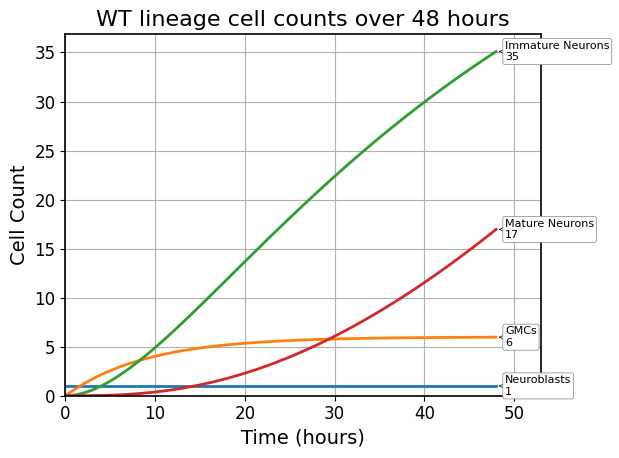

In [ ]:
k_NB = 1/1.5
k_GMC = 1/9.0
k_Neuron = 1/48

# Parameters: [k_NB, k_GMC, k_Neuron, sym_frac]
params = [
    k_NB,    # Neuroblast divides every 1.5 hrs
    k_GMC,   # GMC divides every 9 hrs
    k_Neuron,   # Immature neurons mature every 48 hrs
    0.0      # 0% symmetric NB divisions for WT
]

# Initial conditions: [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
y0 = [1, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 48 hours
t_eval = np.linspace(*t_span, 500)

# Solve ODE
sol = solve_ivp(neuroblast_model, t_span, y0, t_eval=t_eval, args=(params,))

# Plotting
fig, ax = plt.subplots()

labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
y_data = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT lineage cell counts over 48 hours")
ax.grid()
plt.tight_layout()
plt.show()

mudmut Simulation

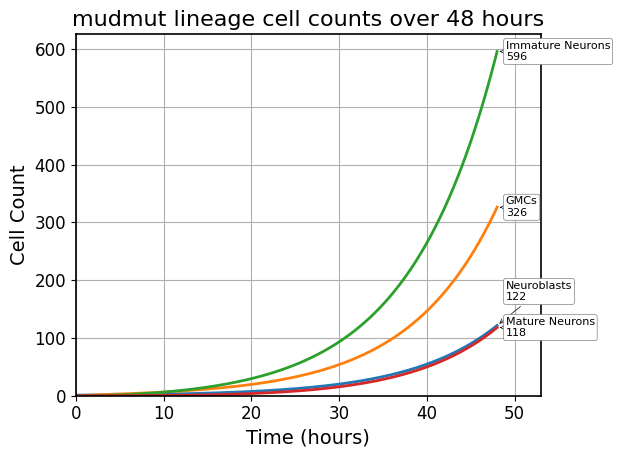

In [9]:
# Parameter value assignment
k_NB = 1/1.5
k_GMC = 1/9.0
k_Neuron = 1/48

# Parameters: [k_NB, k_GMC, k_Neuron, sym_frac]
params = [
    k_NB,   # Neuroblast divides every 1.5 hrs
    k_GMC,   # GMC divides every 9 hrs
    k_Neuron,   # Immature neurons mature every 48 hrs
    0.15      # 15% symmetric NB divisions for mudmut
]

# Initial conditions: [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
y0 = [1, 0, 0, 0]

# Time span
t_span = [0, 48]  # simulate 48 hours
t_eval = np.linspace(*t_span, 500)

# Solve ODE
sol = solve_ivp(neuroblast_model, t_span, y0, t_eval=t_eval, args=(params,))

# Plotting
fig, ax = plt.subplots()

labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
y_data = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for y, label in zip(y_data, labels):
    ax.plot(sol.t, y, label=label)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
annotate_final_values(ax, sol.t, y_data, labels)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut lineage cell counts over 48 hours")
ax.grid()
plt.tight_layout()
plt.show()

---

# NB Division Rate Repressed by NB Count

In this model neuroblast division rate is down-regulated by the number of neuroblasts in the lineage. The feedback follows a Hill equation, where increasing neuroblast count progressively reduces the effective division rate.

### Model Species
- **$N_{\text{NB}}$** — Neuroblasts
- **$N_{\text{GMC}}$** — Ganglion Mother Cells
- **$N_{\text{ImNeuron}}$** — Immature Neurons
- **$N_{\text{MatNeuron}}$** — Mature Neurons

### Parameters
- **$k_{\text{NB,max}}$** — Max NB division rate (1/hr)
- **$k_{\text{GMC}}$** — GMC division rate (1/hr)
- **$k_{\text{Neuron}}$** — Maturation rate (1/hr)
- **$K_{\text{NB,self}},\, n_{\text{self}}$** — Half‑max constant & Hill coefficient for **NB self‑repression**
- **$\text{sym\_frac}$** — Fraction of symmetric NB divisions (unitless)

### Feedback (NB self‑repression only)
$$
k_{\text{NB,eff}} \;=\; k_{\text{NB,max}} \cdot
\frac{K_{\text{NB,self}}^{\,n_{\text{self}}}}{K_{\text{NB,self}}^{\,n_{\text{self}}} + N_{\text{NB}}^{\,n_{\text{self}}}}
$$

### Terms and ODEs
$$
\text{sym\_divs} = \text{sym\_frac}\,k_{\text{NB,eff}}\,N_{\text{NB}},\qquad
\text{asym\_divs} = (1-\text{sym\_frac})\,k_{\text{NB,eff}}\,N_{\text{NB}}.
$$
$$
\frac{dN_{\text{NB}}}{dt} = \text{sym\_divs},\quad
\frac{dN_{\text{GMC}}}{dt} = \text{asym\_divs} - k_{\text{GMC}}\,N_{\text{GMC}},
$$
$$
\frac{dN_{\text{ImNeuron}}}{dt} = 2\,k_{\text{GMC}}\,N_{\text{GMC}} - k_{\text{Neuron}}\,N_{\text{ImNeuron}},\quad
\frac{dN_{\text{MatNeuron}}}{dt} = k_{\text{Neuron}}\,N_{\text{ImNeuron}}.
$$

## Python Code (Neda Skip)

In [10]:
def neuroblast_model_NB_self_repression_only(t, y, params):
    """
    y = [N_NB, N_GMC, N_ImNeuron, N_MatNeuron]
    params = [
        k_NB_max,      # max NB division rate (1/hr)
        k_GMC,         # GMC division rate (1/hr)
        k_Neuron,      # maturation rate (1/hr)
        K_NB_self,     # half-max for NB self-repression (cells)
        n_self,        # Hill coefficient for NB self-repression
        sym_frac       # fraction symmetric NB divisions
    ]
    """
    N_NB, N_GMC, N_Im, N_Mat = y
    k_NB_max, k_GMC, k_Neuron, K_NB_self, n_self, sym_frac = params

    # NB self-repression (Hill-type)
    if K_NB_self <= 0:
        k_NB_eff = k_NB_max
    else:
        k_NB_eff = k_NB_max * (K_NB_self**n_self) / (K_NB_self**n_self + max(N_NB, 0.0)**n_self)

    # Division flows
    sym_divs  = sym_frac * k_NB_eff * N_NB
    asym_divs = (1.0 - sym_frac) * k_NB_eff * N_NB

    # ODEs
    dN_NB  = sym_divs
    dN_GMC = asym_divs - k_GMC * N_GMC
    dN_Im  = 2.0 * k_GMC * N_GMC - k_Neuron * N_Im
    dN_Mat = k_Neuron * N_Im

    return [dN_NB, dN_GMC, dN_Im, dN_Mat]

WT Simulation

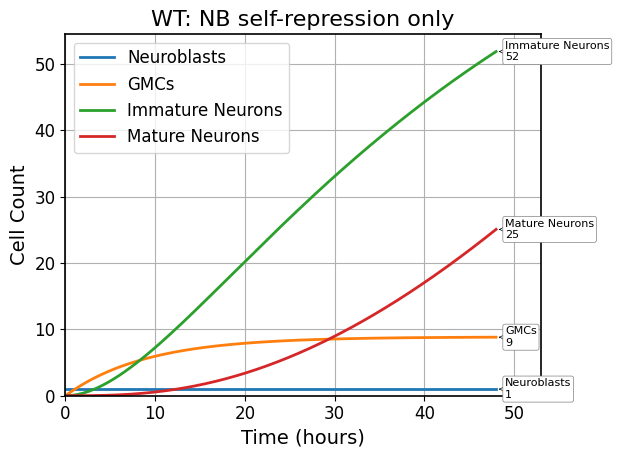

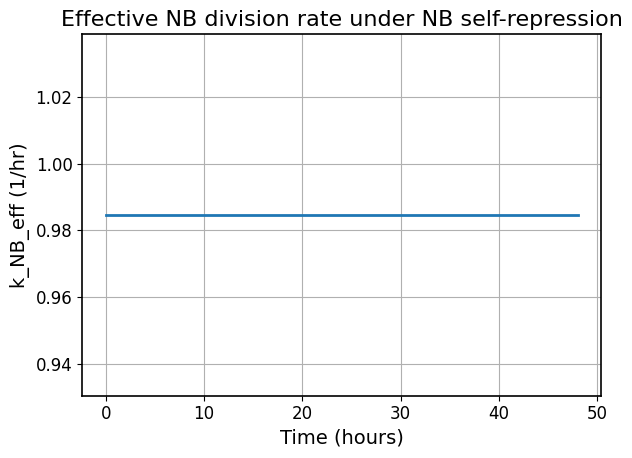

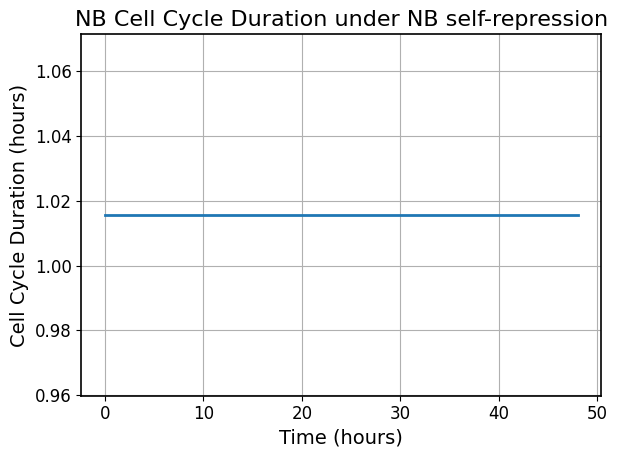

In [11]:
# parameters consistent with earlier choices
k_NB_max   = 1/1      # max NB division rate 1 per hour
k_GMC      = 1/9.0    # avg GMC divides every ~9 h
k_Neuron   = 1/48.0   # avg neuron maturation ~48 h
K_NB_self  = 2.0      # half-max NB count for self-repression
n_self     = 6        # switch-like repression (set to 1 for MM dynamics)
sym_frac   = 0.0      # WT: asymmetric

params = [k_NB_max, k_GMC, k_Neuron, K_NB_self, n_self, sym_frac]

# Initial condition and integration grid
y0 = [1, 0, 0, 0]
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_NB_self_repression_only,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# ---- Plot cell counts ----
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, lab in zip(series, labels):
    ax.plot(sol.t, s, label=lab)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)  # if your helper exists
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("WT: NB self-repression only")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# ---- visualize k_NB_eff over time ----
N_NB = sol.y[0]
if K_NB_self > 0:
    k_NB_eff = k_NB_max * (K_NB_self**n_self) / (K_NB_self**n_self + N_NB**n_self)
else:
    k_NB_eff = k_NB_max * np.ones_like(N_NB)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("k_NB_eff (1/hr)")
ax.set_title("Effective NB division rate under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

# ---- visualize NB cell cycle duration over time ----
# Avoid division by zero
cell_cycle_duration = np.where(k_NB_eff > 0, 1.0 / k_NB_eff, np.nan)

fig, ax = plt.subplots()
ax.plot(sol.t, cell_cycle_duration)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Cycle Duration (hours)")
ax.set_title("NB Cell Cycle Duration under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

mudmut simulation

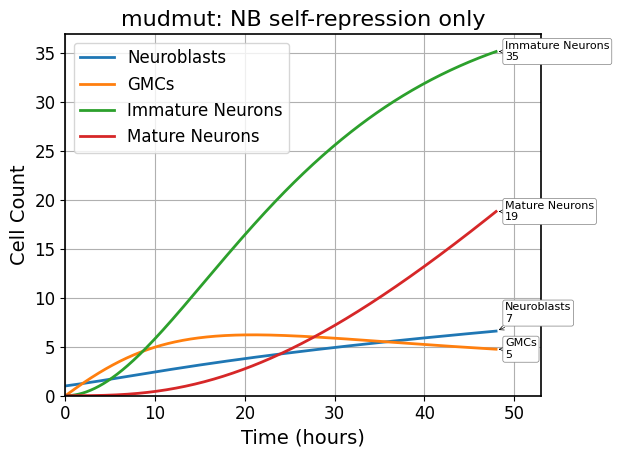

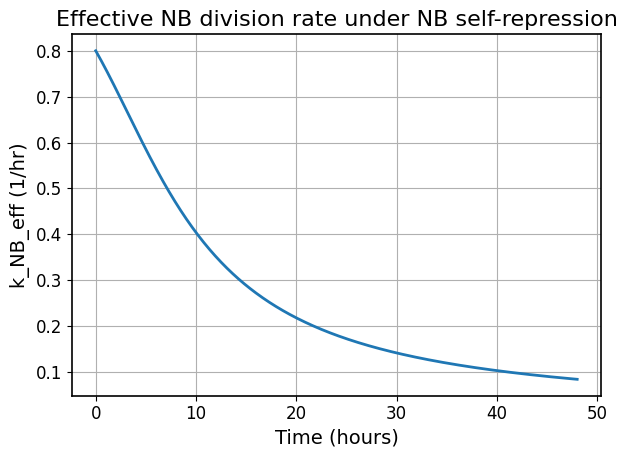

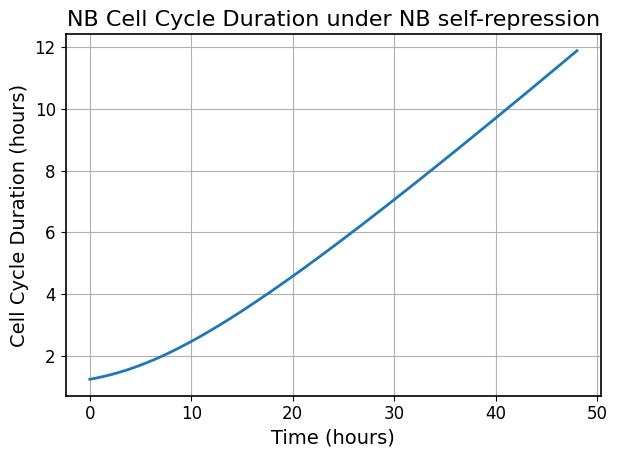

In [12]:
# parameters consistent with earlier choices
k_NB_max   = 1/1      # max NB division rate 1 per hour
k_GMC      = 1/9.0    # avg GMC divides every ~9 h
k_Neuron   = 1/48.0   # avg neuron maturation ~48 h
K_NB_self  = 2.0      # half-max NB count for self-repression
n_self     = 2        # switch-like repression (set to 1 for MM dynamics)
sym_frac   = 0.15     # mudmut: 15% symmetric

params = [k_NB_max, k_GMC, k_Neuron, K_NB_self, n_self, sym_frac]

# Initial condition and integration grid
y0 = [1, 0, 0, 0]
t_span = [0, 48]
t_eval = np.linspace(*t_span, 500)

sol = solve_ivp(
    neuroblast_model_NB_self_repression_only,
    t_span, y0, t_eval=t_eval, args=(params,)
)

# ---- Plot cell counts ----
fig, ax = plt.subplots()
labels = ["Neuroblasts", "GMCs", "Immature Neurons", "Mature Neurons"]
series = [sol.y[0], sol.y[1], sol.y[2], sol.y[3]]

for s, lab in zip(series, labels):
    ax.plot(sol.t, s, label=lab)

ax.set_xlim(0, sol.t[-1] + 5)
ax.set_ylim(bottom=0)
try:
    annotate_final_values(ax, sol.t, series, labels)  # if your helper exists
except NameError:
    pass
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Count")
ax.set_title("mudmut: NB self-repression only")
ax.grid()
ax.legend()
plt.tight_layout()
plt.show()

# ---- visualize k_NB_eff over time ----
N_NB = sol.y[0]
if K_NB_self > 0:
    k_NB_eff = k_NB_max * (K_NB_self**n_self) / (K_NB_self**n_self + N_NB**n_self)
else:
    k_NB_eff = k_NB_max * np.ones_like(N_NB)

fig, ax = plt.subplots()
ax.plot(sol.t, k_NB_eff)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("k_NB_eff (1/hr)")
ax.set_title("Effective NB division rate under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

# ---- visualize NB cell cycle duration over time ----
# Avoid division by zero
cell_cycle_duration = np.where(k_NB_eff > 0, 1.0 / k_NB_eff, np.nan)

fig, ax = plt.subplots()
ax.plot(sol.t, cell_cycle_duration)
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Cell Cycle Duration (hours)")
ax.set_title("NB Cell Cycle Duration under NB self-repression")
ax.grid()
plt.tight_layout()
plt.show()

---